# Load Library Yang Diperlukan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_niblack, threshold_local
import skimage
import cv2
from PIL import Image
import os
import shutil
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
import random
import joblib

# Define Fungsi Yang Diperlukan

In [2]:
def get_freq(img, gray_level=256):
    freq = [0 for i in range(gray_level)]
    for pixel in img.reshape(-1):
        freq[pixel] += 1
    return np.array(freq)

def histogram_equalization(img, gray_level=256):
    freq = get_freq(img, gray_level=gray_level)
    n = len(img.reshape(-1))
    norm_freq = freq/n
    s = [0 for i in range(len(freq))]
    s[0] = norm_freq[0]
    for i in range(1, len(norm_freq)):
        s[i] = norm_freq[i] + s[i-1]
    s = (np.array(s) * (len(freq)-1)).astype(int)
    new_img = [[0 for j in range(img.shape[1])] for i in range(img.shape[0])]
    i = 0
    for row in img:
        j = 0
        for col in row:
            new_img[i][j] = s[col]
            j += 1
        i += 1
    return np.array(new_img)

In [3]:
def load_image(file_name, img_size=300):
    sample_image = cv2.imread(file_name)
    img = cv2.cvtColor(sample_image,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(img_size, img_size))

    return img

def apply_otsu_method(img):
    img_gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray = histogram_equalization(img_gray).astype(np.uint8)
    img_gray = skimage.filters.gaussian(img_gray, sigma=5.0)

    thresh = threshold_otsu(img_gray)

    img_otsu  = img_gray > thresh if thresh > 0.4825 and thresh < 0.5175 else img_gray < thresh
    return img_otsu

def filter_image(image, mask):
    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask

    return np.dstack([r,g,b])

def preprocess_image_from_path(file_name):
    img = load_image(file_name)
    mask = apply_otsu_method(img)
    preprocessed_img = filter_image(img, mask)
    return img, mask, preprocessed_img

def preprocess_image(img):
    mask = apply_otsu_method(img)
    preprocessed_img = filter_image(img, mask)
    return preprocessed_img

def load_images_from_path(data_path, img_size=300):
    labels = os.listdir(data_path)
    X = []
    y = []
    for label in labels:
        label_path = os.path.join(data_path, label)
        file_names = os.listdir(label_path)
        for file_name in file_names:
            file_path = os.path.join(label_path, file_name)
            X.append(load_image(file_path, img_size=img_size))
            y.append(label)
    X = np.array(X)
    y = np.array(y)
    print(f"Found {len(X)} images belonging to {len(np.unique(y))} classes.")
    return X, y

def preprocess_image_pipeline(images):
    X = []
    for image in images:
        prep_img = preprocess_image(image)
        features = get_freq(prep_img)
        X.append(features)
    return np.array(X)

In [4]:
def getPerformance(y_pred, y_test):
    ac = accuracy_score(y_pred, y_test)
    p = precision_score(y_pred, y_test, average="macro")
    r = recall_score(y_pred, y_test, average="macro")
    f = f1_score(y_pred, y_test, average="macro")
    return [ac, p, r, f]

def getSummary(model, X_train, X_val, y_train, y_val):
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_train)
    trainp = getPerformance(pred_train, y_train)
    valp = getPerformance(pred_val, y_val)
    p_list = ["Accuracy", "Precision", "Recall", "F1"]
    performance_df = pd.DataFrame(p_list, columns=["Performance"])
    performance_df["Train Data"] = trainp
    performance_df["Testing Data"] = valp
    return pred_train, pred_val, performance_df

In [5]:
def formatData(data):
    label_encoder = LabelEncoder()
    formatted_data = label_encoder.fit_transform(data)
    le_idx_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    return formatted_data, le_idx_mapping, le_name_mapping

In [6]:
def plot_conf_matrix(y, pred, mapping):
    y_true = np.vectorize(lambda x: mapping[x])(y)
    y_pred = np.vectorize(lambda x: mapping[x])(pred)
    cm_labels = np.unique(y_true)
    cm_array = confusion_matrix(y_true, y_pred)
    cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
    sns.heatmap(cm_array_df, annot=True, square=True, fmt='.0f', annot_kws={'size': 10}, cmap="Spectral_r")
    plt.show()

In [7]:
def encode_idx(labels):
    n_class = len(np.unique(labels))
    y = []
    for label in labels:
        enc = np.zeros(n_class)
        enc[label] = 1
        y.append(enc)
    y = np.array(y)
    return y

# Load Images Data

In [8]:
img_size = 224

In [9]:
train_path = "./Dataset/train"
X_train, y_train = load_images_from_path(train_path, img_size=img_size)

Found 50 images belonging to 5 classes.


In [10]:
X_train.shape

(50, 224, 224, 3)

In [11]:
y_train.shape

(50,)

In [12]:
test_path = "./Dataset/test"
X_test, y_test = load_images_from_path(test_path, img_size=img_size)

Found 25 images belonging to 5 classes.


In [13]:
X_test.shape

(25, 224, 224, 3)

In [14]:
y_test.shape

(25,)

# Show Images and Preprocessed Images

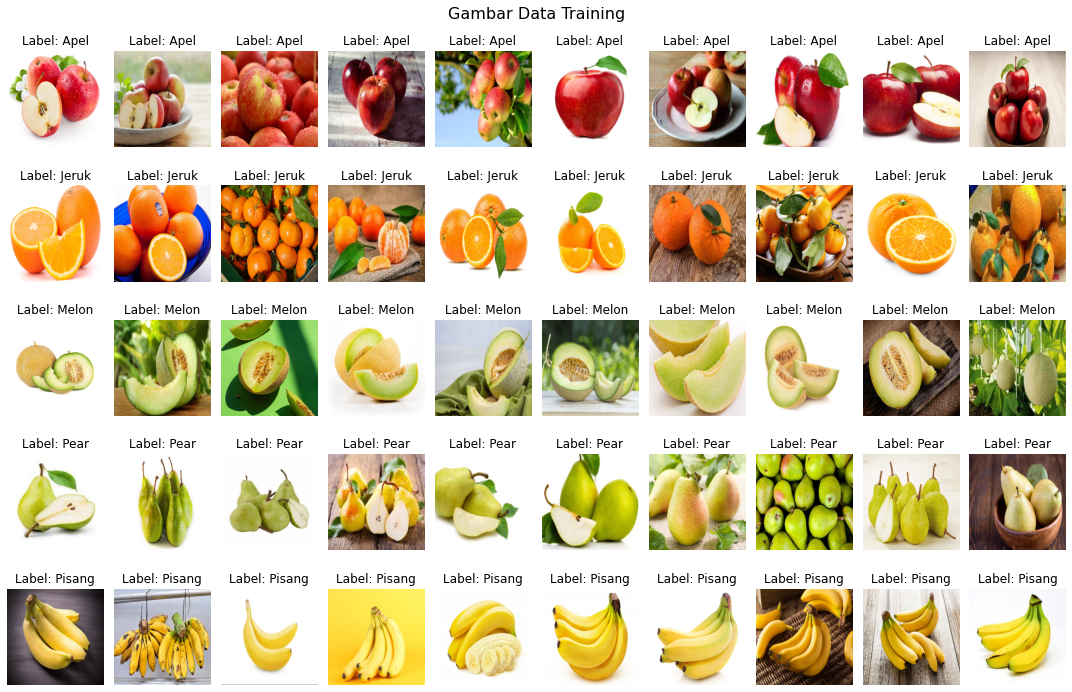

In [15]:
num_row = 5
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[i], cmap='gray')
    ax.set_axis_off()
    ax.set_title('Label: {}'.format(y_train[i]))
fig.suptitle("Gambar Data Training", fontsize=16)
plt.tight_layout()
plt.show()

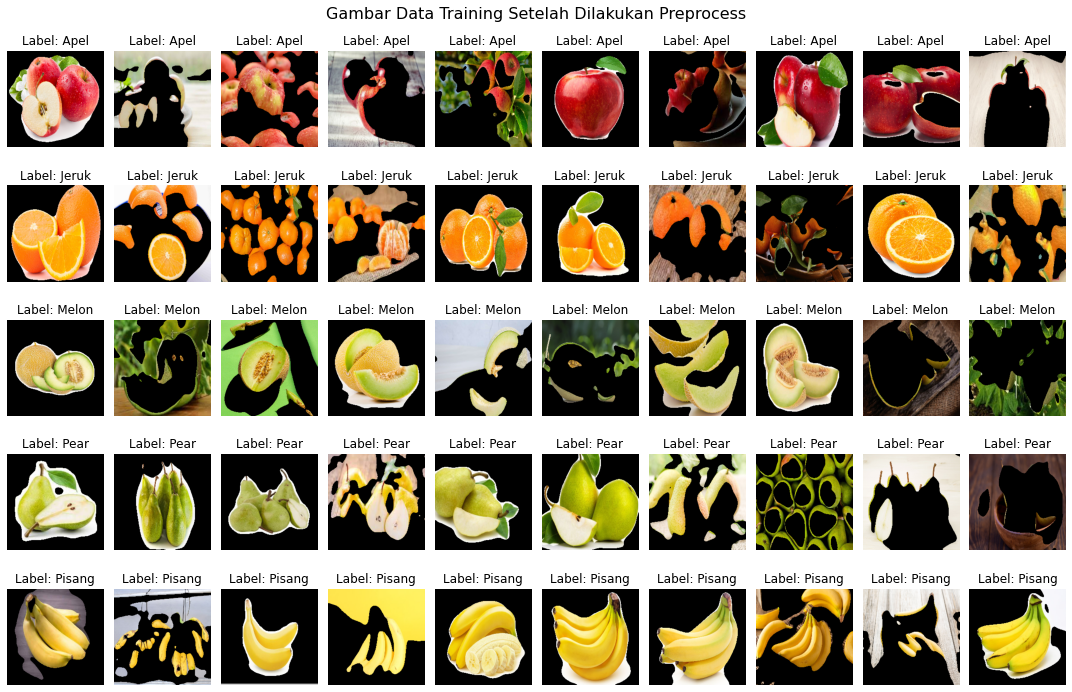

In [16]:
num_row = 5
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(preprocess_image(X_train[i]), cmap='gray')
    ax.set_axis_off()
    ax.set_title('Label: {}'.format(y_train[i]))
fig.suptitle("Gambar Data Training Setelah Dilakukan Preprocess", fontsize=16)
plt.tight_layout()
plt.show()

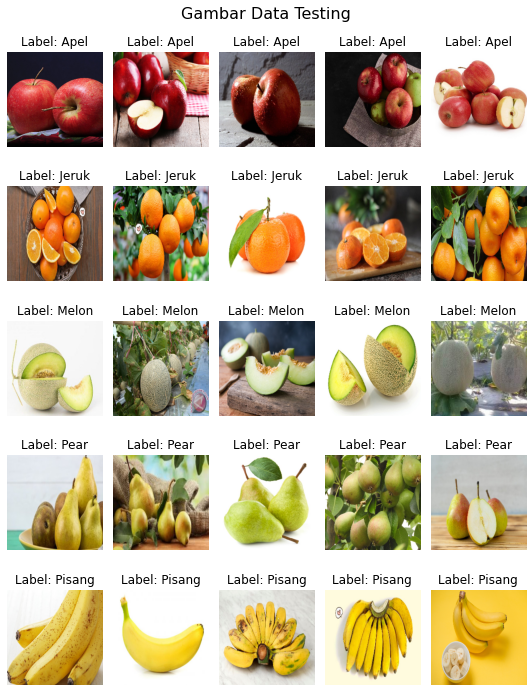

In [17]:
num_row = 5
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.set_axis_off()
    ax.set_title('Label: {}'.format(y_test[i]))
fig.suptitle("Gambar Data Testing", fontsize=16)
plt.tight_layout()
plt.show()

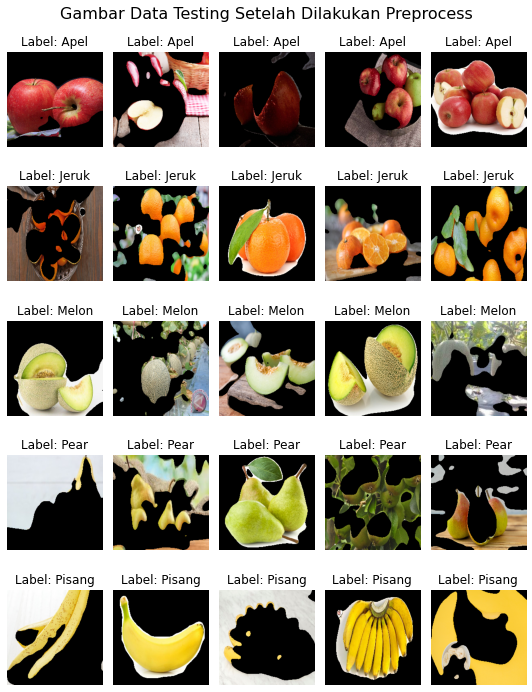

In [18]:
num_row = 5
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(preprocess_image(X_test[i]), cmap='gray')
    ax.set_axis_off()
    ax.set_title('Label: {}'.format(y_test[i]))
fig.suptitle("Gambar Data Testing Setelah Dilakukan Preprocess", fontsize=16)
plt.tight_layout()
plt.show()

# Modeling Program 1: Non Deep Learning

## Data Preparation
* Format Label into Numeric

In [19]:
y_train, mapping_idx_label, mapping_name_label = formatData(y_train)
y_test = np.vectorize(lambda x: mapping_name_label[x])(y_test)
mapping_name_label

{'Apel': 0, 'Jeruk': 1, 'Melon': 2, 'Pear': 3, 'Pisang': 4}

In [20]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4], dtype=int64)

In [21]:
y_test

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4])

## Define Pipeline Model

In [22]:
pipe = Pipeline(
    [
        ('preprocess', FunctionTransformer(preprocess_image_pipeline)),
        ('scaler', StandardScaler()), 
        ('svc', SVC(random_state=42))
    ]
)

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function preprocess_image_pipeline at 0x000001979B52C0D0>)),
                ('scaler', StandardScaler()), ('svc', SVC(random_state=42))])

## Evaluasi

In [24]:
pred_train, pred_test, performance_df = getSummary(pipe, X_train, X_test, y_train, y_test)
performance_df

Performance  Train Data  Testing Data
0    Accuracy    0.780000      0.600000
1   Precision    0.780000      0.600000
2      Recall    0.807208      0.640476
3          F1    0.781690      0.612121

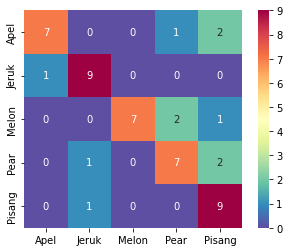

In [25]:
plot_conf_matrix(y_train, pred_train, mapping_idx_label)

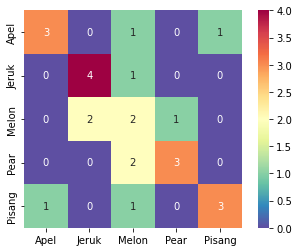

In [26]:
plot_conf_matrix(y_test, pred_test, mapping_idx_label)

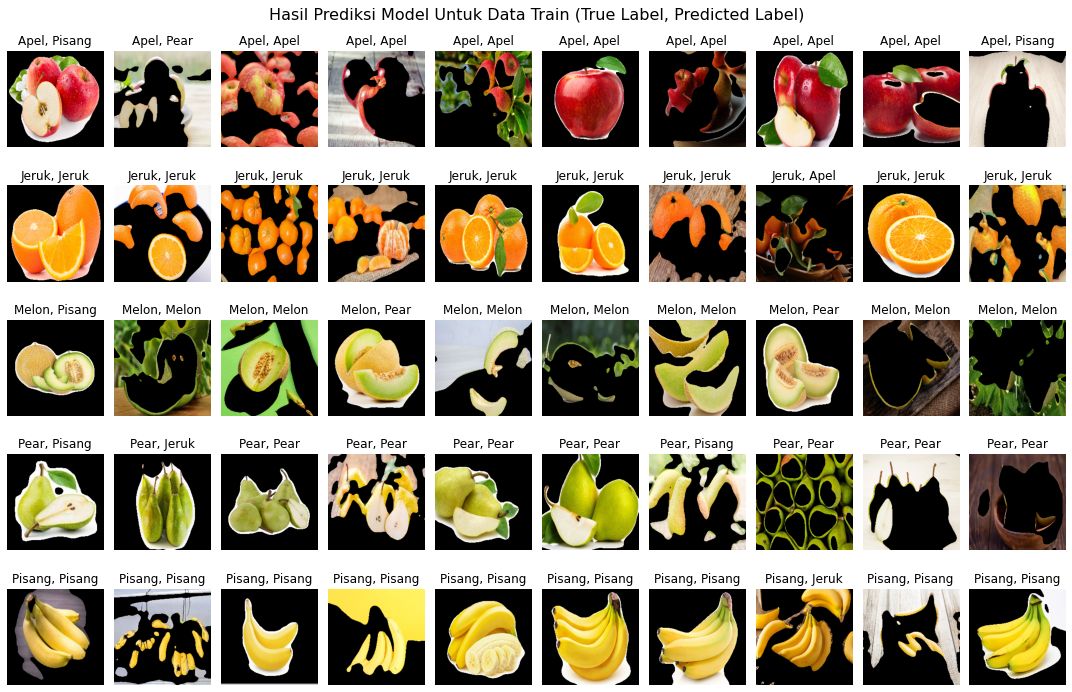

In [27]:
num_row = 5
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(preprocess_image(X_train[i]), cmap='gray')
    ax.set_axis_off()
    ax.set_title('{}, {}'.format(mapping_idx_label[y_train[i]], mapping_idx_label[pred_train[i]]))
fig.suptitle("Hasil Prediksi Model Untuk Data Train (True Label, Predicted Label)", fontsize=16)
plt.tight_layout()
plt.show()

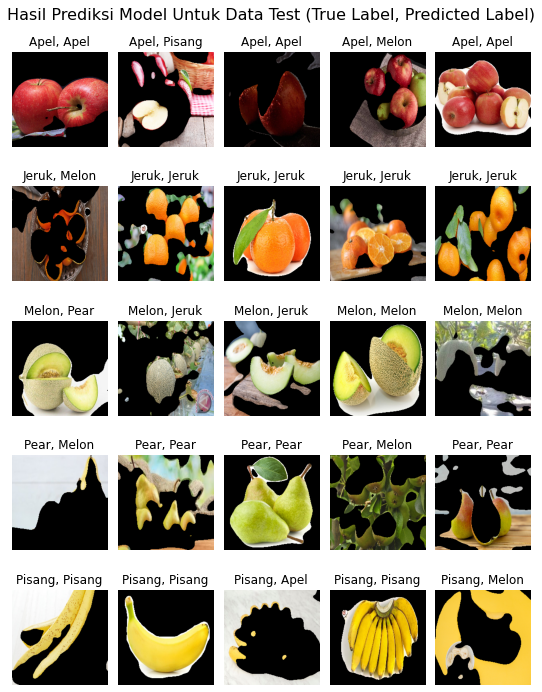

In [28]:
num_row = 5
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(preprocess_image(X_test[i]), cmap='gray')
    ax.set_axis_off()
    ax.set_title('{}, {}'.format(mapping_idx_label[y_test[i]], mapping_idx_label[pred_test[i]]))
fig.suptitle("Hasil Prediksi Model Untuk Data Test (True Label, Predicted Label)", fontsize=16)
plt.tight_layout()
plt.show()

## Save Pipeline Model 

In [29]:
joblib.dump(pipe, 'non_deep_learning_model.pickle')

['non_deep_learning_model_2.pickle']

In [30]:
joblib.load('non_deep_learning_model.pickle').predict(X_test)

array([0, 4, 0, 2, 0, 2, 1, 1, 1, 1, 3, 1, 1, 2, 2, 2, 3, 3, 2, 3, 4, 4,
       0, 4, 2], dtype=int64)

# Modeling Program 2: Deep Learning

## Encode Label 

In [31]:
y_train_dl = encode_idx(y_train)
y_test_dl = encode_idx(y_test)

## Normalize Data Train

In [32]:
X_train_dl = X_train / 255.0
X_test_dl = X_test /255

## Define Model Deep Learning

In [33]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu, input_shape=(img_size, img_size, 3)),
        tf.keras.layers.MaxPooling2D(3, 3),
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(5, activation='softmax')
])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

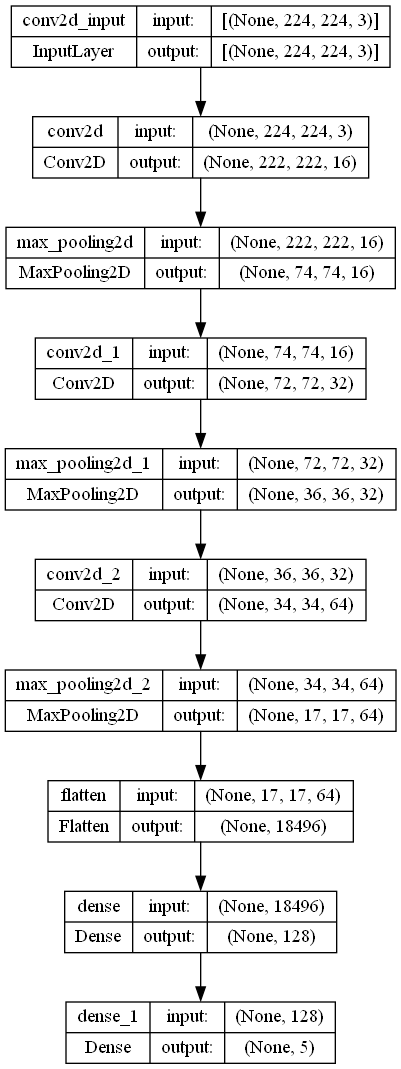

In [35]:
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## Compile Model

In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Define Callbacks

In [37]:
# Create callbacks so when desired accuracy and validation accuracy the model stop training
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
            print("\nReached >90% accuracy for training and validation datasets so cancelling training!")
            self.model.stop_training = True

In [38]:
callbacks = myCallback()

## Train Model

In [39]:
history = model.fit(
    X_train_dl,
    y_train_dl,
    epochs=20,
    validation_data=(X_test_dl, y_test_dl),
    callbacks=callbacks
)

Epoch 1/20
2/2 [==============================] - 3s 1s/step - loss: 1.8656 - accuracy: 0.2000 - val_loss: 1.9021 - val_accuracy: 0.2800
Epoch 2/20
2/2 [==============================] - 1s 621ms/step - loss: 1.8887 - accuracy: 0.3400 - val_loss: 1.6995 - val_accuracy: 0.4000
Epoch 3/20
2/2 [==============================] - 1s 552ms/step - loss: 1.5905 - accuracy: 0.5000 - val_loss: 1.5259 - val_accuracy: 0.2000
Epoch 4/20
2/2 [==============================] - 1s 600ms/step - loss: 1.3886 - accuracy: 0.3600 - val_loss: 1.3860 - val_accuracy: 0.5200
Epoch 5/20
2/2 [==============================] - 1s 577ms/step - loss: 1.2470 - accuracy: 0.7200 - val_loss: 1.2827 - val_accuracy: 0.4400
Epoch 6/20
2/2 [==============================] - 1s 513ms/step - loss: 1.0894 - accuracy: 0.6200 - val_loss: 1.1611 - val_accuracy: 0.5600
Epoch 7/20
2/2 [==============================] - 1s 560ms/step - loss: 0.8843 - accuracy: 0.6800 - val_loss: 1.0068 - val_accuracy: 0.4800
Epoch 8/20
2/2 [=======

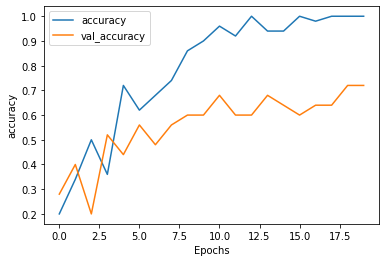

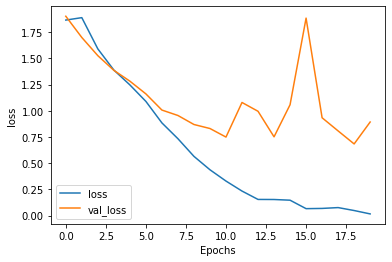

In [40]:
# Plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Evaluasi

In [41]:
pred_train = np.argmax(model.predict(X_train), axis=1)
pred_train.shape

2/2 [==============================] - 1s 117ms/step


(50,)

In [42]:
pred_test = np.argmax(model.predict(X_test), axis=1)
pred_test.shape

1/1 [==============================] - 0s 205ms/step


(25,)

In [43]:
perf_train = getPerformance(pred_train, y_train)
perf_test = getPerformance(pred_test, y_test)
perf_label = ["Accuracy", "Precision", "Recall", "F1 Score"]
perf_df = pd.DataFrame(data=perf_label, columns=["Performance"])
perf_df["Training Set"] = perf_train
perf_df["Testing Set"] = perf_test
perf_df

Performance  Training Set  Testing Set
0    Accuracy           1.0     0.720000
1   Precision           1.0     0.720000
2      Recall           1.0     0.836111
3    F1 Score           1.0     0.691148

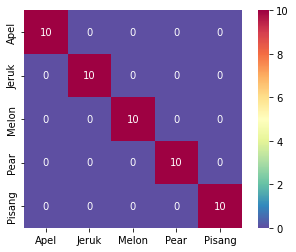

In [44]:
plot_conf_matrix(y_train, pred_train, mapping_idx_label)

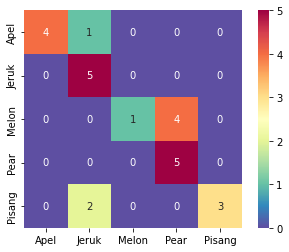

In [45]:
plot_conf_matrix(y_test, pred_test, mapping_idx_label)

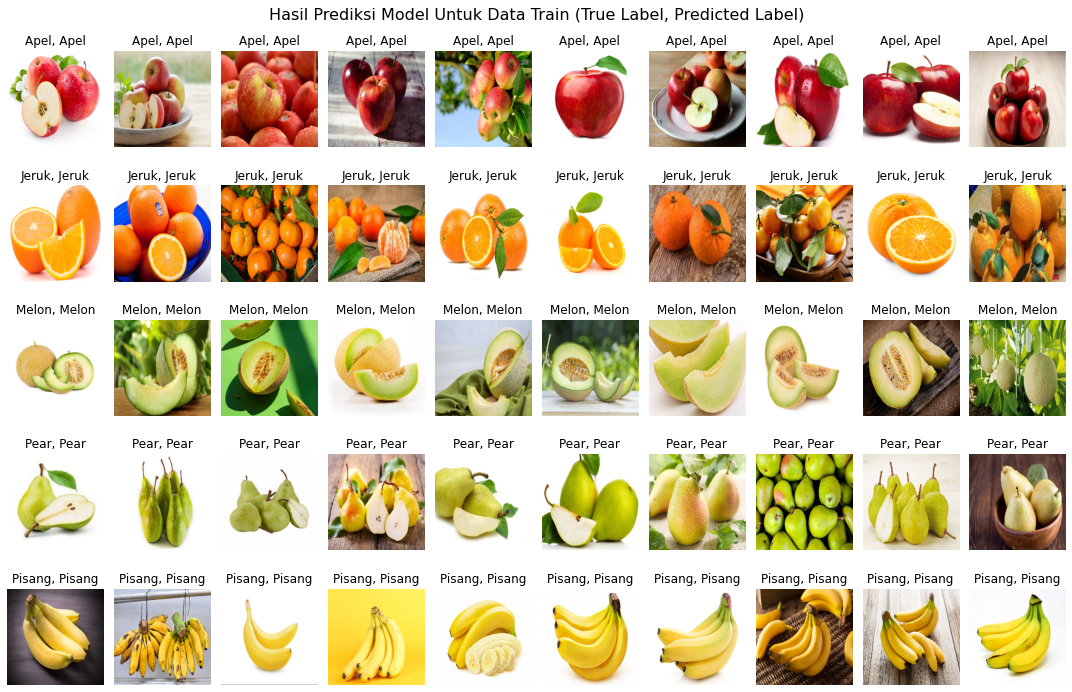

In [46]:
num_row = 5
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[i], cmap='gray')
    ax.set_axis_off()
    ax.set_title('{}, {}'.format(mapping_idx_label[y_train[i]], mapping_idx_label[pred_train[i]]))
fig.suptitle("Hasil Prediksi Model Untuk Data Train (True Label, Predicted Label)", fontsize=16)
plt.tight_layout()
plt.show()

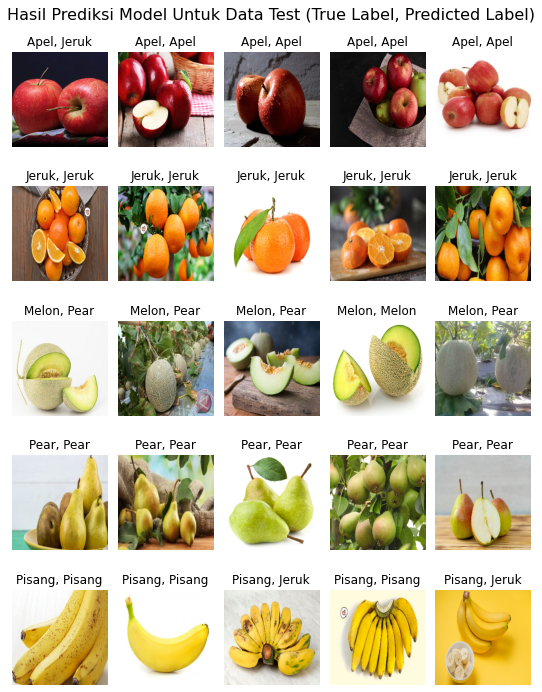

In [47]:
num_row = 5
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.set_axis_off()
    ax.set_title('{}, {}'.format(mapping_idx_label[y_test[i]], mapping_idx_label[pred_test[i]]))
fig.suptitle("Hasil Prediksi Model Untuk Data Test (True Label, Predicted Label)", fontsize=16)
plt.tight_layout()
plt.show()

## Save Deep Learning Model

In [48]:
model.save('deep_learning_model.h5')